# model building



### from Data Preparation

In [1]:
# Import the relevant libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import math
import json
plt.rc("font", size=14)
import seaborn as sns
sns.set()
sns.set(style="whitegrid", color_codes=True)

In [2]:
# Read in the csv files
offer_df = pd.read_csv('total_issued_offer.csv')
customer_df = pd.read_csv('customer_df.csv')
rfm_df = pd.read_csv('rfm_score.csv')

In [3]:
offer_df.rename(columns={'id':'customer_id'},inplace=True)
customer_df.rename(columns={'id':'customer_id'},inplace=True)
rfm_df.rename(columns={'id':'customer_id'},inplace=True)

In [4]:
# Merge all the datasets
customer_offer_df_mod = offer_df.merge(customer_df, left_on = 'customer_id', right_on ='customer_id', how='left')
customer_offer_df =customer_offer_df_mod.merge(rfm_df, left_on = 'customer_id', right_on ='customer_id', how='left').fillna(0)

In [5]:
customer_offer_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76277 entries, 0 to 76276
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       76277 non-null  object 
 1   days              76277 non-null  int64  
 2   offer_id          76277 non-null  object 
 3   max_offer_day     76277 non-null  float64
 4   offer_type        76277 non-null  object 
 5   desirable_use     76277 non-null  object 
 6   gender            76277 non-null  object 
 7   age               76277 non-null  int64  
 8   became_member_on  76277 non-null  object 
 9   income            76277 non-null  float64
 10  days_as_member    76277 non-null  int64  
 11  recency           76277 non-null  float64
 12  frequency         76277 non-null  float64
 13  monetary          76277 non-null  float64
dtypes: float64(5), int64(3), object(6)
memory usage: 8.7+ MB


In [6]:
# Drop the unnecessary features 
customer_offer_df.drop(['became_member_on','days','max_offer_day','offer_id'],axis =1, inplace= True)

In [7]:
total_issued_bogo = customer_offer_df.query('offer_type =="bogo"')
total_issued_disc = customer_offer_df.query('offer_type =="discount"')
total_issued_info = customer_offer_df.query('offer_type =="informational"')

### Characteristics of the Dataset

#### 1. Imbalanced Data 

In [8]:
print('BOGO Offer:' )
print(total_issued_bogo.desirable_use.value_counts())
print(' ')
print('Discount Offer:' )
print(total_issued_disc.desirable_use.value_counts())
print(' ')
print('Informational Offer:' )
print(total_issued_info.desirable_use.value_counts())

BOGO Offer:
non-desirable    25129
desirable         5370
Name: desirable_use, dtype: int64
 
Discount Offer:
non-desirable    24075
desirable         6468
Name: desirable_use, dtype: int64
 
Informational Offer:
non-desirable    14048
desirable         1187
Name: desirable_use, dtype: int64


<AxesSubplot:xlabel='offer_type', ylabel='count'>

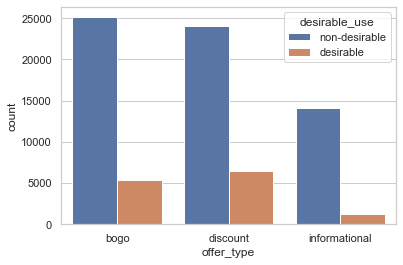

In [9]:
offer_order =['bogo', 'discount','informational']
sns.countplot(data= customer_offer_df, x= 'offer_type', hue = 'desirable_use', order = offer_order)

> The size of 'informational' offer class is very low. It consist of 9,86% of all datapoints only. Imbalanced data


#### 2. Classification Feature Selection 


Running the example first creates the regression dataset, then defines the feature selection and applies the feature selection procedure to the dataset, returning a subset of the selected input features. 


In [10]:
# Import necessary libraries 
from sklearn.feature_selection import f_classif

# chi-squared test with similar proportions
from scipy.stats import chi2_contingency
from scipy.stats import chi2

In [11]:
def Feature_selection(offer_df):
    
    # Target variable: 'desirable_use'
    categorical_target = offer_df.desirable_use
    
    selected_inputs = []
    
    # Numerical Inputs Selection 
    numerical_inputs = offer_df.drop(['customer_id','desirable_use','gender','offer_type'], axis =1)
    
    anova_test = f_classif(numerical_inputs, categorical_target)
    
    prob = 0.95
    alpha = 1.0 - prob
    
    for i in range(len(anova_test[1])):
        if anova_test[1][i] < alpha:
            selected_inputs.append(numerical_inputs.columns[i])
    
    # Categorical Inputs Selection 
    categorical_input = offer_df['gender']
    gender_df = pd.get_dummies(offer_df.gender, prefix = 'gender', prefix_sep = '_')
    gender_df['desirable_use'], gender_df['customer_id'] = offer_df['desirable_use'], offer_df['customer_id']
    
    contingency_table = gender_df.groupby(['desirable_use'], as_index = True).sum()
    stat, p, dof, expected = chi2_contingency(contingency_table.values)
       
    if p <= alpha:
        selected_inputs.append('gender')

        
    return offer_df[selected_inputs]


In [12]:
bogo_df = Feature_selection(total_issued_bogo)
discount_df = Feature_selection(total_issued_disc)
informational_df = Feature_selection(total_issued_info)


In [13]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

def endcoder(col):
    d1=col['desirable_use']
    col['desirable_use']=label_encoder.fit_transform(d1)
endcoder(total_issued_bogo)
endcoder(total_issued_disc)
endcoder(total_issued_info)


C:\Users\sai\AppData\Local\Temp\ipykernel_4604\3356983487.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col['desirable_use']=label_encoder.fit_transform(d1)


<a id='Analysis'></a>
## 4. Data Analysis  

&emsp;4.2. Data Spliting <br>
&emsp;4.3. Data Balancing <br>
&emsp;4.4. Model Comparison <br>
&emsp;4.5. Model Evaluation <br>
&emsp;4.6. Model Selection<br>
### 4. 2. Data Spliting

In [14]:
from sklearn.model_selection import train_test_split


test_size = 0.2
random_state = 42

bogo_target= total_issued_bogo.desirable_use
disc_target= total_issued_disc.desirable_use
info_target= total_issued_info.desirable_use



#### Train & Test Data

In [16]:
# Bogo
bogo_trainX, bogo_testX, bogo_trainy, bogo_testy = train_test_split(bogo_df, bogo_target, 
                                                                  test_size=test_size, random_state=random_state)
# Discount
disc_trainX, disc_testX, disc_trainy, disc_testy = train_test_split(discount_df, disc_target, 
                                                                    test_size=test_size, random_state=random_state)
# Informational
info_trainX, info_testX, info_trainy, info_testy = train_test_split(informational_df, info_target, 
                                                                    test_size=test_size, random_state=random_state)

In [17]:
# !pip install imblearn
print(bogo_testy)

6206     1
72911    1
35231    1
12173    1
37034    1
        ..
3752     1
38532    1
47504    1
54740    1
39628    1
Name: desirable_use, Length: 6100, dtype: int32



### 4. 3. Data Balancing 

In [18]:
# check version number
import imblearn
print(imblearn.__version__)

# Import necessary libraries 
from imblearn.over_sampling import SMOTE
from collections import Counter

0.10.1


In [19]:
import collections
print('         BOGO Training Data: ',collections.Counter(bogo_trainy) )
print('     Discount Training Data: ',collections.Counter(disc_trainy) )
print('Informational Training Data: ',collections.Counter(info_trainy) )

         BOGO Training Data:  Counter({1: 20108, 0: 4291})
     Discount Training Data:  Counter({1: 19243, 0: 5191})
Informational Training Data:  Counter({1: 11244, 0: 944})


In [22]:
def Balancing_Data(X_train, y_train): 
    
    # Decide how many the minority class should be oversampled 
    
    nondes_train = int(collections.Counter(y_train)[1])
    # des_train = int(collections.Counter(y_train)['desirable']*4)
    des_train = int(nondes_train*0.7)
    
    # Transform the dataset
    strategy = { 1:nondes_train, 0:des_train}
    oversample = SMOTE(sampling_strategy=strategy)
    
    # Balanced dataset 
    X_balanced, y_balanced = oversample.fit_resample( X_train, y_train)
    
    # Summarize newly balanced Distribution
    counter = Counter(y_balanced)
    for k,v in counter.items():
        per = v / len(y_balanced) * 100
        print('Class=%s, n=%d (%.3f%%)' % (k, v, per))
        
    # Plot the distribution
    plt.bar(counter.keys(), counter.values())
    plt.show()
    
    balanced_train = pd.concat([X_balanced, y_balanced],axis=1)
    
    return balanced_train
    

Class=1, n=20108 (58.825%)
Class=0, n=14075 (41.175%)


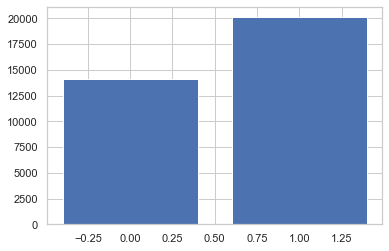

Class=1, n=19243 (58.824%)
Class=0, n=13470 (41.176%)


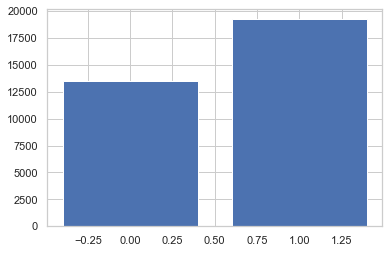

Class=0, n=7870 (41.174%)
Class=1, n=11244 (58.826%)


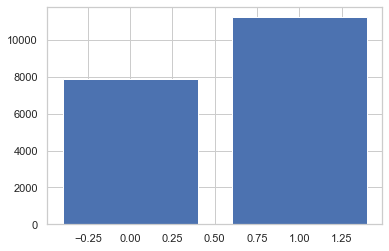

In [23]:
balanced_bogo = Balancing_Data(bogo_trainX, bogo_trainy)
balanced_disc = Balancing_Data(disc_trainX, disc_trainy)
balanced_info = Balancing_Data(info_trainX, info_trainy)

In [24]:
# !pip install xgboost 
# !pip install lightgbm
# !pip install catboost

### 4. 4. Model Comparison

- Sklearn Ensemble Methods (Random Forest, AdaBoost, GradientBoost)
- XGBoost vs. LightGBM vs. CatBoost  
- LogisticRegression 


In [25]:
# Import necessary libraries 
# 1. Sklearn Ensemble Methods
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier) 

# 2. XG Boost vs. Light GBM vs. CatBoost
import xgboost as xgb # XG Boost 
import lightgbm as lgbm # Light GBM
import catboost as cb # CatBoost

# 3. A Benchmark Model
from sklearn.linear_model import LogisticRegression 

# Evaluation tools 
from sklearn import metrics
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score 

from time import time # To measure execution time of the model 

#### Set up the models 

In [26]:
# 1. Sklearn Ensemble Methods
rf = RandomForestClassifier(n_estimators=500, max_features=0.06, n_jobs=6, class_weight = 'balanced', 
                            verbose = 0, random_state=42)

base_estim = DecisionTreeClassifier(max_depth=1, max_features=0.06)                            
ab = AdaBoostClassifier(base_estimator=base_estim, n_estimators=500, learning_rate=0.5, random_state=42)

gbm = GradientBoostingClassifier(n_estimators=2000, subsample=0.75, max_features=0.06, verbose = 0,  validation_fraction=0.1, random_state=42)

In [27]:
# 2. XG Boost vs. Light GBM vs. CatBoost
xgb = xgb.XGBClassifier(n_estimators=2000, tree_method='hist', subsample=0.75, 
                        objective = 'binary:logistic', n_jobs=6, random_state=42)

lgbm = lgbm.LGBMClassifier(n_estimators=2000, n_jobs=6, random_state=42)
                          

cb =  cb.CatBoostClassifier(n_estimators=2000, colsample_bylevel=0.06, max_leaves=31, subsample=0.75, 
                            thread_count=6, verbose = 0, random_state=42)

In [28]:
# 3. A Benchmark Model
logreg = LogisticRegression(random_state=42, class_weight = 'balanced')

In [29]:
models = [logreg, rf, ab, gbm, xgb, lgbm, cb]
model_names = [i.__class__.__name__ for i in models]
es_models = ['XGBClassifier', 'LGBMClassifier', 'CatBoostClassifier']

#### Train and Evaluate the models 

In [30]:
def Train_Evaluate_Models(balanced_df, test_inputs, test_target):
    
    # Identify target and inputs variables
    balanced_target= balanced_df.desirable_use
    balanced_inputs= balanced_df.drop(['desirable_use'], axis=1)
    
    # Create a validation sample from balanced training data 
    trainX_sub, trainX_valid, trainy_sub, trainy_valid = train_test_split(balanced_inputs, balanced_target, test_size=0.1)
    
    # Set up a dataframe to contain the results
    results = pd.DataFrame(columns=['accuracy','prediction','recall','f1_score', 'run_time'])  
    
    # Training the models 
    for m, n in zip(models, model_names):
    
        start_time = time()
        if n in es_models:
            m.fit(trainX_sub, trainy_sub,
                  eval_set = [(trainX_valid, trainy_valid)], 
                  early_stopping_rounds=15, verbose=0)
        else:
            m.fit(balanced_inputs, balanced_target)
    
        run_time = time() - start_time

        y_pred = m.predict(test_inputs)
        accuracy = np.mean( y_pred == test_target)
        precision = precision_score(test_target, y_pred, average= 'weighted', zero_division=0)
        recall = recall_score(test_target, y_pred, average= 'weighted', zero_division=0)
        f1_score = 2 * (precision * recall) / (precision + recall)

        results.loc[n] = [accuracy,precision, recall, f1_score, run_time]

        del m
    
    return results
    

In [33]:
Train_Evaluate_Models(balanced_bogo, bogo_testX, bogo_testy)

C:\Users\sai\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\sai\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\sai\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


,accuracy,prediction,recall,f1_score,run_time
LogisticRegression,0.637213,0.755204,0.637213,0.691209,0.199466
RandomForestClassifier,0.724426,0.733889,0.724426,0.729127,11.576044
AdaBoostClassifier,0.720000,0.766715,0.720000,0.742624,8.620943
GradientBoostingClassifier,0.803443,0.738672,0.803443,0.769697,41.518965
XGBClassifier,0.800656,0.739860,0.800656,0.769058,1.093074
LGBMClassifier,0.811803,0.742468,0.811803,0.775589,1.662553
CatBoostClassifier,0.716066,0.767301,0.716066,0.740798,6.285193


In [34]:
Train_Evaluate_Models(balanced_disc, disc_testX, disc_testy)

C:\Users\sai\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\sai\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\sai\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


,accuracy,prediction,recall,f1_score,run_time
LogisticRegression,0.619578,0.724111,0.619578,0.667778,0.179514
RandomForestClassifier,0.689475,0.694859,0.689475,0.692156,13.139859
AdaBoostClassifier,0.704862,0.734045,0.704862,0.719158,8.306785
GradientBoostingClassifier,0.772139,0.704180,0.772139,0.736596,40.813848
XGBClassifier,0.762645,0.697080,0.762645,0.728390,1.061159
LGBMClassifier,0.778523,0.700977,0.778523,0.737718,1.291547
CatBoostClassifier,0.697004,0.728685,0.697004,0.712493,7.342363


In [35]:
Train_Evaluate_Models(balanced_info, info_testX, info_testy)

C:\Users\sai\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\sai\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\sai\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


,accuracy,prediction,recall,f1_score,run_time
LogisticRegression,0.642927,0.878463,0.642927,0.742463,0.108709
RandomForestClassifier,0.856252,0.860967,0.856252,0.858603,7.549810
AdaBoostClassifier,0.779455,0.871325,0.779455,0.822834,5.175158
GradientBoostingClassifier,0.904824,0.856669,0.904824,0.880088,31.089854
XGBClassifier,0.893010,0.851404,0.893010,0.871711,1.533900
LGBMClassifier,0.907122,0.856630,0.907122,0.881153,1.839080
CatBoostClassifier,0.760092,0.871811,0.760092,0.812127,10.054111


### 4. 5. Model Selection 
> **LGBMClassifier** <br>
> For all type of offers,  "LGBMClassifier" shows one of the outstanding model performances. Also the model performed well within a short period of time. In this section, I additionally compare several input features that show significant difference between 'desirably' predicted samples and 'non-desirably' predicted samples. 

In [36]:
bogo_all_results = pd.DataFrame(lgbm.predict(bogo_testX), columns=['predicted_target'])
bogo_predicted = pd.concat([bogo_testX.reset_index(), bogo_all_results], axis=1)

In [37]:
disc_all_results = pd.DataFrame(lgbm.predict(disc_testX), columns=['predicted_target'])
disc_predicted = pd.concat([disc_testX.reset_index(), disc_all_results], axis=1)


In [38]:
info_all_results = pd.DataFrame(lgbm.predict(info_testX), columns=['predicted_target'])
info_predicted = pd.concat([info_testX.reset_index(), info_all_results], axis=1)

Text(0.5, 1.0, 'Monetary Value (BOGO)')

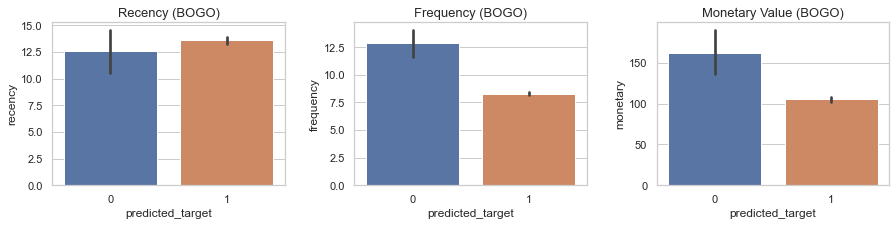

In [39]:
plt.figure(figsize=[15,3]) 
plt.subplots_adjust(wspace = 0.3 , hspace= 0.1)

plt.subplot(1, 3, 1)
sns.barplot(data = bogo_predicted, x = 'predicted_target', y = 'recency')
plt.title('Recency (BOGO)', fontsize = 13)

plt.subplot(1, 3, 2)
sns.barplot(data = bogo_predicted, x = 'predicted_target', y = 'frequency')
plt.title('Frequency (BOGO)', fontsize = 13)

plt.subplot(1, 3, 3)
sns.barplot(data = bogo_predicted, x = 'predicted_target', y = 'monetary')
plt.title('Monetary Value (BOGO)', fontsize = 13)

Text(0.5, 1.0, 'Monetary (Discount)')

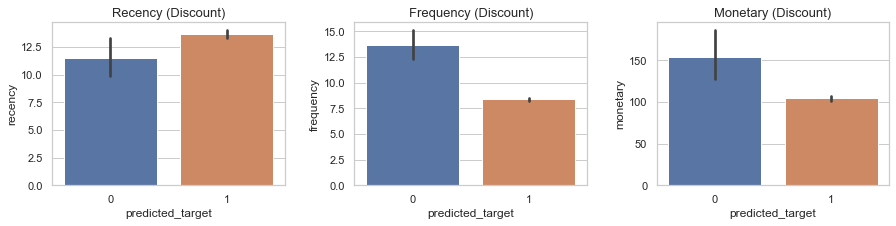

In [40]:
plt.figure(figsize=[15,3]) 
plt.subplots_adjust(wspace = 0.3 , hspace= 0.5)

plt.subplot(1, 3, 1)
sns.barplot(data = disc_predicted, x = 'predicted_target', y = 'recency')
plt.title('Recency (Discount)', fontsize = 13)

plt.subplot(1, 3, 2)
sns.barplot(data = disc_predicted, x = 'predicted_target', y = 'frequency')
plt.title('Frequency (Discount)', fontsize = 13)

plt.subplot(1, 3, 3)
sns.barplot(data = disc_predicted, x = 'predicted_target', y = 'monetary')
plt.title('Monetary (Discount)', fontsize = 13)

Text(0.5, 1.0, 'Monetary (Informational)')

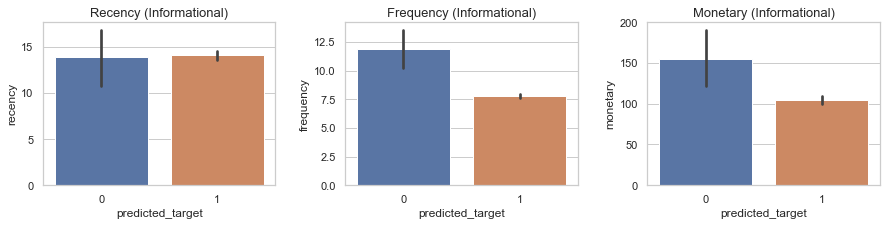

In [41]:
plt.figure(figsize=[15,3]) 
plt.subplots_adjust(wspace = 0.3 , hspace= 0.5)

plt.subplot(1, 3, 1)
sns.barplot(data = info_predicted, x = 'predicted_target', y = 'recency')
plt.title('Recency (Informational)', fontsize = 13)

plt.subplot(1, 3, 2)
sns.barplot(data = info_predicted, x = 'predicted_target', y = 'frequency')
plt.title('Frequency (Informational)', fontsize = 13)

plt.subplot(1, 3, 3)
sns.barplot(data = info_predicted, x = 'predicted_target', y = 'monetary')
plt.title('Monetary (Informational)', fontsize = 13)

<a id='Conclusion'></a>
## 5. Conclusion

> In this analysis, I analysed how Starbucks customers use offers based on the transaction data. The customer profile dataset contains a few missing data. These missing values are imputed by the median value of each features. Imputation with its own median values has several advantages. Since the median value is one of the existing values, it is realistic. Also it makes the distribution less skewed. 
By adjusting the existing features in transcript dataframe, I convert the time column into day, and month columns. <br><br>
> Using the cleaned data, I explored current business situations. The number of traffics varies in each month. It increased until the third month. The change of sales amounts follows almost identical patterns with the change of traffics. We can understand that more traffics bring better sales performances. Interestingly, although the number of traffics and sales amount are different in each month, the average spending per each transaction is remarkably similar across the months. <br><br>
> All customers in the profile dataset purchased products at Starbucks, although not all of them received offers. The average age of customers are 54.5 years old, and their average yearly income is around 65227. There is no significant difference between genders regarding the received type of offers. Finally, the total number of offers and the number of each type of offers are not correlated with customer's ages, incomes, the number of days as a Starbucks member. <br><br>
> The number of issued offers is unbalanced. 'BOGO' and 'Discount' types of offers are almost evenly distributed; around 30000. On the other hand, "Informational" type of offer is issued only the half of them (ca. 15000). Not all of the issued offers are viewed. Only 75,68% (= 57725/76277) of offers are checked by customers. Only half of issued 'BOGO' and 'discount' offers are completed. <br><br>
>  In addition, I explored customer purchasing patterns based on RFM analysis. RFM is an evaluation method to analyse customer value. It is often used in database marketing especially in retail and professional services industries. RFM indicates the following 3 dimensions: Recency, Frequency, Monetary Value. <br><br>
> As mentioned in Capstone proposal, I defined the desirably used offers by both Case 1 and Case 2. Based on the definition, I identified all offer usages into 2 groups: 'desirable', 'non-desirable' per each offer type. As you can see the first bar chart in the part 2, all three datasets highly imbalanced. Therefore, I alleviated the unbalanced datasets by applying Synthetic Minority Oversampling Technique (SMOTE). Then I trained each dataset with various classification models.  <br><br>
>For all type of offers, "LGBMClassifier" showed the optimal model performances. It achieved 0.7742, 0.7388, 0.8830 of f1-score for bogo, discount, informational datasets, respectively, within the shorter period of time. The f1-score is considerably larger than that of the benchmark model. Also the time duration is much shorter than that of the benchmark model. The model with LGBMClassifier is more efficient than the benchmark model. 